Colab tutorial for uploading data. 

https://colab.research.google.com/notebooks/io.ipynb

In [38]:
import h5py
import numpy as np

filepath = 'Rat08-20130711_017.h5'  # data file
f = h5py.File(filepath, 'r')  # read data with h5 format
fs = f.attrs['fs'][0]  # get sampling frequency of LFP signal (Hz)
print("Sampling rate: %.1f Hz" % (fs))

Sampling rate: 1250.0 Hz


In [39]:
states = []  # two states (NREM & WAKE) to be classified
# LFP recordings are store in two h5 groups for each state
# Under each h5 group, the LFP recordings are divided into several segments with different lengths.
for name, grp in f.items():
  states.append(name)
  print("State: %s" % (name))
  print("Segment IDs:")
  print(list(grp.keys()))

State: NREM
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '7', '8', '9']
State: WAKE
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '4', '5', '6', '7', '8', '9']


In [ ]:
# Convert the recording in to numpy arrays
# Use a dictionary to store the LFP recordings of the two states
# each containing a list of numpy arrays of all segments
lfp = {key: [] for key in states}
for key in states:
  group = f[key]  # h5 group of a state
  n = len(group)  # number of segments
  for i in range(n):
    lfp[key].append(group[str(i+1)][()].astype(float))  # convert data to numpy array and from int type to float type

print(lfp)

Example for accessing a segment.

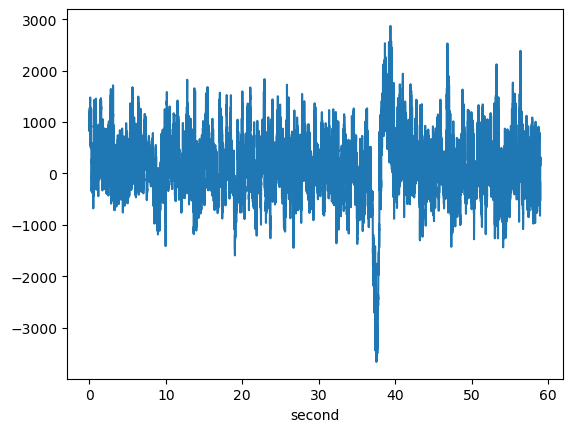

In [52]:
import matplotlib.pyplot as plt

x = lfp['NREM'][10]  # accessing the 10-th LFP segment in NREM state
t = np.arange(x.size)/fs  # time points

plt.plot(t,x)
plt.xlabel('second')
plt.show()

In [51]:
from scipy import stats
import pandas as pd

# LFP Training NN

This is the set up of the program to set up the initial sampling rate clip length and samples

In [40]:
sampling_rate = 1250 # This is the sampling rate in hz
clip_length_sec = 5
clip_length_samples = sampling_rate * clip_length_sec

def segment_signal(signal, clip_len): # determines the segments for signal
    clips = []
    for start in range(0, len(signal) - clip_len + 1, clip_len):
        clips.append(signal[start:start + clip_len])
    return np.array(clips)

In [41]:
from scipy.stats import skew, kurtosis
from scipy.signal import welch

def extract_features(clips, fs): # Based on the video to from the lectures to train it and answers qualify for the second requirement on doc
    features = []
    for clip in clips:
        mean = np.mean(clip)
        std = np.std(clip)
        skw = skew(clip)
        krt = kurtosis(clip)

        freqs, psd = welch(clip, fs, nperseg=fs)
        band_power = np.trapz(psd[(freqs >= 0.5) & (freqs <= 4)])  # Delta band as example
        
        features.append([mean, std, skw, krt, band_power])
    return np.array(features) # Returns a numpy array of the features for the calcs of metrics

In [42]:
from sklearn.preprocessing import StandardScaler

# Scale the numerical features in the array `X`
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

In [43]:
from sklearn.model_selection import train_test_split

# Create a DataFrame with the state labels

df = pd.DataFrame({'state': ['NREM'] * len(X_nrem) + ['WAKE'] * len(X_wake)})
labels = df['state'].values
# create the splits for training and testing to see loss
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class FFN(nn.Module): # model for the NN and training to forward pass through
    def __init__(self, input_size):
        super(FFN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.layers(x)

model = FFN(input_size=X_train.shape[1])

In [36]:
from sklearn.preprocessing import LabelEncoder

# Encode string labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Create TensorDataset
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_encoded, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.7502
Epoch 2, Loss: 0.1066
Epoch 3, Loss: 0.0279
Epoch 4, Loss: 0.0158
Epoch 5, Loss: 0.5363
Epoch 6, Loss: 0.0035
Epoch 7, Loss: 0.0624
Epoch 8, Loss: 0.1666
Epoch 9, Loss: 0.0043
Epoch 10, Loss: 0.0210
Epoch 11, Loss: 0.0023
Epoch 12, Loss: 0.0011
Epoch 13, Loss: 0.0005
Epoch 14, Loss: 0.0004
Epoch 15, Loss: 0.0000
Epoch 16, Loss: 0.0034
Epoch 17, Loss: 0.0051
Epoch 18, Loss: 0.0037
Epoch 19, Loss: 0.2097
Epoch 20, Loss: 0.4264


This is for the arranging the clips into segments and returns an array seperated into the two

In [45]:

def segment_signal(signal, fs, clip_duration_sec=5):
    clip_len = fs * clip_duration_sec
    return [
        signal[i:i + clip_len] 
        for i in range(0, len(signal) - clip_len + 1, clip_len)
    ]

# Segment all clips per state
segmented = {'NREM': [], 'WAKE': []}
for state in lfp:
    for segment in lfp[state]:
        segmented[state].extend(segment_signal(segment, int(fs)))

This is to calculate the signal clips and sampling freq into PSD using welches method as demonstrated in the video but extended a bit for the segments

In [46]:
from scipy.signal import welch

def extract_psd_features(clips, fs):
    features = []
    for clip in clips:
        freqs, psd = welch(clip, fs, nperseg=fs//2)

        def band_power(low, high):
            mask = (freqs >= low) & (freqs <= high)
            return np.trapz(psd[mask], freqs[mask])

        feature = [
            band_power(0.5, 4),    # delta
            band_power(4, 8),      # theta
            band_power(8, 12),     # alpha
            band_power(12, 30),    # beta
            band_power(30, 100)    # gamma
        ]
        features.append(feature)
    return np.array(features)

X_nrem = extract_psd_features(segmented['NREM'], int(fs))
X_wake = extract_psd_features(segmented['WAKE'], int(fs))

/var/folders/jj/vdvh5h8n303gtfkqp70hlw9c0000gn/T/ipykernel_97601/3485045039.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[mask], freqs[mask])


In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = np.vstack([X_nrem, X_wake])
y = np.array([0] * len(X_nrem) + [1] * len(X_wake))

# Normalize the features according to the documentation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

This is the same loop to train again and measure the accuracy of the model on classification tasks

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Model
class FFN(nn.Module):
    def __init__(self, input_dim):
        super(FFN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.layers(x)

model = FFN(X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training args below with the loop to train forward and backwards prop

In [49]:
# Prepare tensors
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Training loop
for epoch in range(20):
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 43.1384
Epoch 2, Loss: 22.8548
Epoch 3, Loss: 19.9297
Epoch 4, Loss: 19.1134
Epoch 5, Loss: 18.3389
Epoch 6, Loss: 17.6406
Epoch 7, Loss: 17.5941
Epoch 8, Loss: 16.8518
Epoch 9, Loss: 16.2076
Epoch 10, Loss: 15.9181
Epoch 11, Loss: 15.5497
Epoch 12, Loss: 15.7386
Epoch 13, Loss: 15.4301
Epoch 14, Loss: 14.9920
Epoch 15, Loss: 15.6679
Epoch 16, Loss: 15.1463
Epoch 17, Loss: 14.6412
Epoch 18, Loss: 14.5909
Epoch 19, Loss: 14.5019
Epoch 20, Loss: 14.5603


Below is for measuring accuracy of the model after training which is around 93 percent

In [50]:
model.eval()
with torch.no_grad():
    test_tensor = torch.tensor(X_test, dtype=torch.float32)
    pred_probs = model(test_tensor)
    predictions = torch.argmax(pred_probs, axis=1).numpy()
    accuracy = (predictions == y_test).mean()
    print(f"Accuracy: {accuracy:.2%}")

Accuracy: 93.35%


## Conclusion

Some issues I had throughout this project was extracting the data and ensuring it stays accurate with the labels given for each. The training and hyperparameters engineering was a trail and error as well to try and increase the accuracy on the model. Most functions were built into libraries so it was easier to calculate metrics that are measured in steps 2 which was useful. Using a custom training loop caused much more issues then maybe using a library like huggingface which trains supported models but since this is a NN it made more sense. The accuracy turned out to be high which was due to several iteration of testing out different hyper parameters for the model and ensuring that they gave better training for the NN model. 